In [1]:
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import h5py
import scipy.stats
import random
from matplotlib.pyplot import *
from statsmodels.nonparametric import smoothers_lowess
import statsmodels.stats.multitest
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import glob

sns.set_style("ticks")
%matplotlib inline

In [2]:
mydir = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/"

In [3]:
f_out_file = mydir+'data/20200103_data_freeze/differentiation_trajectories/cell_fractions.all_timepoints.all_complete_trajectories.tsv'
pca_out_file = mydir+'data/20200103_data_freeze/differentiation_trajectories/cell_fractions.all_timepoints.all_complete_trajectories.PCA.tsv'

In [4]:
fraction_file_dict = {'D11':mydir+'data/data_processed/pool1_13_noddd_D11/pool1_13_noddd_D11.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.celltype_fractions.tsv',
                     'D30':mydir+'data/data_processed/pool1_13_noddd_D30/pool1_13_noddd_D30.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.celltype_fractions.tsv',
                     'D52':mydir+'data/data_processed/pool1_17_D52/pool1_17_D52.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.celltype_fractions.tsv'}


timepoints = ['D11','D30','D52']

cell_threshold = 10

list_of_dfs = []
for timepoint in timepoints:
    fraction_file = fraction_file_dict[timepoint]
    count_file = fraction_file.replace('fractions','counts')
    frac_df = pd.read_csv(fraction_file, sep='\t')
    count_df = pd.read_csv(count_file, sep='\t')

    frac_df['donor_pool_label'] = frac_df['donor_id'] + ':' + frac_df['pool_id']
    count_df['donor_pool_label'] = count_df['donor_id'] + ':' + count_df['pool_id']
    donor_pool_counts = count_df.groupby('donor_pool_label').sum()
    selected_donor_pools = donor_pool_counts[donor_pool_counts['n_cells']>=cell_threshold].index
    frac_df = frac_df.query('donor_pool_label in @selected_donor_pools')
    
    frac_df['label'] = frac_df['celltype'] + '_' + frac_df['time_point'].astype(str)
    df = frac_df.set_index(['donor_id','pool_id'])[['label','f_cells']]
    df = df.pivot(columns='label')

    df.columns = df.columns.get_level_values(1)

    # fill 0 for any fraction that didn't have any cells in it
    df = df.fillna(0.0)
    print(df.shape)
    list_of_dfs.append(df)

# drop nas so we have a set of complete trajectories
df2 = pd.concat(list_of_dfs, axis=1).dropna()

# df2.to_csv(f_out_file, sep='\t')

df2['diff_efficiency'] = df2[['DA_D52','Sert_D52']].sum(axis=1, skipna=False)

print(df2.shape)
df2.head()

(197, 3)
(199, 7)
(227, 10)
(159, 21)


label                      FPP_D11    NB_D11  P_FPP_D11  Astro_D30  CHem_D30  \
donor_id         pool_id                                                       
HPSI0114i-eipl_1 pool1    0.536413  0.073147   0.390440   0.298340  0.333462   
HPSI0114i-wegi_1 pool6    0.550422  0.000000   0.449578   0.138306  0.005069   
                 pool7    0.671111  0.004444   0.324444   0.050243  0.000000   
HPSI0115i-aion_2 pool4    0.558459  0.002751   0.438790   0.106042  0.012330   
HPSI0115i-aoxv_1 pool8    0.539179  0.030585   0.430236   0.372009  0.072763   

label                       DA_D30  Epen1_D30  P_FPP_D30  Sert_D30  \
donor_id         pool_id                                             
HPSI0114i-eipl_1 pool1    0.019684   0.253570   0.044384  0.005403   
HPSI0114i-wegi_1 pool6    0.101376   0.006155   0.099566  0.649529   
                 pool7    0.523501   0.001621   0.034036  0.390600   
HPSI0115i-aion_2 pool4    0.552404   0.054254   0.025894  0.246609   
HPSI0115i-aoxv_1 pool8    0.084235   0.298591   0.049492  0.122255   

label                     unknown_D30  ...  CHem_D52    DA_D52  Epen1_D52  \
donor_id         pool_id               ...                                  
HPSI0114i-eipl_1 pool1       0.045156  ...  0.090457  0.009562   0.138153   
HPSI0114i-wegi_1 pool6       0.000000  ...  0.000864  0.047235   0.007200   
                 pool7       0.000000  ...  0.000000  0.592955   0.000000   
HPSI0115i-aion_2 pool4       0.002466  ...  0.015531  0.313201   0.149267   
HPSI0115i-aoxv_1 pool8       0.000656  ...  0.048641  0.081317   0.534048   

label                     Epen2_D52   FPP_D52  P_FPP_D52  P_Sert_D52  \
donor_id         pool_id                                               
HPSI0114i-eipl_1 pool1     0.003085  0.157895   0.079699    0.000193   
HPSI0114i-wegi_1 pool6     0.000288  0.047811   0.002016    0.002592   
                 pool7     0.000000  0.011742   0.000000    0.000000   
HPSI0115i-aion_2 pool4     0.003451  0.085418   0.010354    0.008628   
HPSI0115i-aoxv_1 pool8     0.017710  0.108506   0.022948    0.004989   

label                     Sert_D52  unknown_D52  diff_efficiency  
donor_id         pool_id                                          
HPSI0114i-eipl_1 pool1    0.003316     0.005707         0.012878  
HPSI0114i-wegi_1 pool6    0.861463     0.028802         0.908698  
                 pool7    0.293542     0.084149         0.886497  
HPSI0115i-aion_2 pool4    0.398619     0.010354         0.711821  
HPSI0115i-aoxv_1 pool8    0.139935     0.015964         0.221252  

[5 rows x 21 columns]

In [5]:
df2.rename(columns={'DA_D52' : 'DA_D52',
                    'Astro_D30' : 'FPP_D30',
                    'DA_D30' : 'DA_D30',
                    'P_FPP_D11' : 'P_FPP_D11', 
                    'FPP_D52' : 'FPP_D52',
                    'Sert_D52' : 'Sert_D52',
                    'FPP_D11' : 'FPP_D11', 
                    'NB_D11' : 'NB_D11', 
                    'CHem_D30' : 'U_Neur1_D30', 
                    'P_FPP_D30' : 'P_FPP_D30',
                    'Epen1_D52' : 'Epen1_D52', 
                    'Astro_D52' : 'Astro_D52', 
                    'CHem_D52' : 'U_Neur1_D52', 
                    'Epen1_D30' : 'Epen1_D30', 
                    'P_FPP_D52' : 'P_FPP_D52',
                    'unknown_D30' : 'U_Neur2_D30', 
                    'Sert_D30' : 'Sert_D30', 
                    'Epen2_D52' : 'Epen2_D52', 
                    'unknown_D52' : 'U_Neur3_D52',
                    'P_Sert_D52' : 'P_Sert_D52'}, 
                 inplace=True)

In [6]:
df2.mean()

label
FPP_D11            0.531279
NB_D11             0.038397
P_FPP_D11          0.430324
FPP_D30            0.211465
U_Neur1_D30        0.071727
DA_D30             0.311643
Epen1_D30          0.113886
P_FPP_D30          0.068702
Sert_D30           0.218467
U_Neur2_D30        0.004109
Astro_D52          0.099506
U_Neur1_D52        0.049013
DA_D52             0.191908
Epen1_D52          0.212813
Epen2_D52          0.007596
FPP_D52            0.121688
P_FPP_D52          0.034224
P_Sert_D52         0.004833
Sert_D52           0.263227
U_Neur3_D52        0.015193
diff_efficiency    0.455134
dtype: float64

In [7]:
df3 = df2.loc[:, df2.mean()>0.02]

order = ['P_FPP_D11','FPP_D11','NB_D11',
         'P_FPP_D30','FPP_D30','Epen1_D30','U_Neur1_D30','DA_D30','Sert_D30',
         'P_FPP_D52','FPP_D52','Astro_D52','Epen1_D52','U_Neur1_D52', 'DA_D52','Sert_D52']

df3 = df3[order]

df3.columns

Index(['P_FPP_D11', 'FPP_D11', 'NB_D11', 'P_FPP_D30', 'FPP_D30', 'Epen1_D30',
       'U_Neur1_D30', 'DA_D30', 'Sert_D30', 'P_FPP_D52', 'FPP_D52',
       'Astro_D52', 'Epen1_D52', 'U_Neur1_D52', 'DA_D52', 'Sert_D52'],
      dtype='object', name='label')

Text(981.6500000000001, 0.5, '')

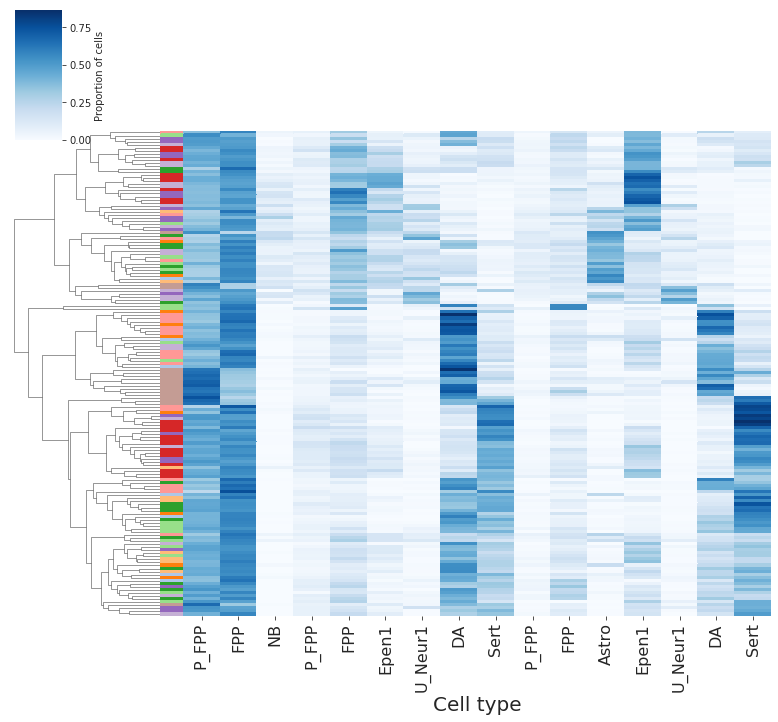

In [8]:

from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib import cm, colors


# default matplotlib 2.0 palette
# see 'category20' on https://github.com/vega/vega/wiki/Scales#scale-range-literals
vega_20 = list(map(colors.to_hex, cm.tab20.colors))

colors = ["#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#4a6fe3",
    "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", "#11c638", "#8dd593",
    "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7",
    "#f3e1eb", "#f6c4e1", "#f79cd4",
    '#7f7f7f', "#c7c7c7", "#1CE6FF", "#336600"]
colors = vega_20

color_dict = dict([('pool{}'.format(x), colors[x]) for x in range(20)])

row_colors = df3.reset_index()['pool_id'].apply(lambda x: color_dict[x]).tolist()


row_linkage = hierarchy.linkage(distance.pdist(df3.values), method='average', metric='euclidean')


FS = 16

fig = sns.clustermap(df3, row_linkage=row_linkage, row_colors=row_colors, method="average",
                    figsize=(13, 10), cmap='Blues', col_cluster=False,
                    cbar_kws={"ticks":[0,0.25,0.5,0.75],"label":'Proportion of cells'})

ax = fig.ax_heatmap
ax.set_xlabel("Cell type", fontsize=FS+4)
ax.set_yticks([])
ax.set_xticklabels([x.split('_D')[0] for x in df3.columns], fontsize=FS)
ax.set_ylabel("")


# fig_title = '../../figures/differentiation_trajectories/heatmap_complete_differentiation_trajectories.png'
# fig.savefig(fig_title, dpi=200, bbox_inches='tight')
# fig.savefig(fig_title.replace('.png','.svg'), bbox_inches='tight')

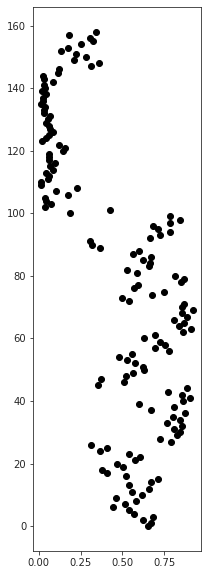

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (3,10)

plot(fig.data2d[['DA_D52','Sert_D52']].sum(axis=1),range(fig.data2d.shape[0])[::-1], 'ko')

In [10]:
# import re

# re.search('HPSI1054i-fiaj_1',df2.index.values)
# df2['HPSI1054i-fiaj_1'].index.values
# df2['HPSI1054i-fiaj_1',:]
# df2.index.isin('HPSI1054i-fiaj_1')
fig.data2d.head()

,label,P_FPP_D11,FPP_D11,NB_D11,P_FPP_D30,FPP_D30,Epen1_D30,U_Neur1_D30,DA_D30,Sert_D30,P_FPP_D52,FPP_D52,Astro_D52,Epen1_D52,U_Neur1_D52,DA_D52,Sert_D52
donor_id,pool_id,,,,,,,,,,,,,,,,
HPSI1014i-tixi_4,pool7,0.366667,0.583333,0.050000,0.067771,0.314759,0.049699,0.015060,0.453313,0.099398,0.040055,0.142265,0.052486,0.393646,0.005525,0.252762,0.087017
HPSI0714i-kute_5,pool5,0.550000,0.416667,0.033333,0.033058,0.198347,0.074380,0.115702,0.471074,0.107438,0.011111,0.233333,0.088889,0.388889,0.100000,0.066667,0.111111
HPSI1014i-vils_1,pool8,0.494784,0.502732,0.002484,0.075260,0.339965,0.067474,0.056228,0.252595,0.208478,0.021910,0.207865,0.001685,0.414045,0.022472,0.185393,0.118539
HPSI0914i-zerv_7,pool8,0.506243,0.483541,0.010216,0.065126,0.193277,0.144958,0.025210,0.373950,0.197479,0.034924,0.233993,0.000000,0.370198,0.018626,0.161816,0.159488
HPSI1113i-hayt_3,pool9,0.497843,0.497162,0.004994,0.066083,0.301173,0.052536,0.041963,0.417809,0.120106,0.039937,0.175959,0.013246,0.457098,0.013444,0.111309,0.139779


In [15]:
fig.data2d.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/sc_neuroseq/pca_celltype_fractions_heatmap_df.csv")